# Imports & Dataset

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import zipfile

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-01-11 16:29:41--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.74.20.142, 2600:1417:9800:393::e59, 2600:1417:9800:39e::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.74.20.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  71.1MB/s    in 17s     

2021-01-11 16:29:58 (47.3 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


# Process the Training Data

In [4]:
# Set to True to rebulid the training data, or load the traning data in the next cell
REBULID_DATA = True

# Data processing class
class DogsVSCats():
  IMG_SIZE = 50
  CATS = "/tmp/PetImages/Cat/"
  DOGS = "/tmp/PetImages/Dog/"
  LABELS = {CATS: 0, DOGS:1}
  training_data = []
  catcount = 0
  dogcount = 0

  def make_training_data(self):
        for label in self.LABELS:
          print(label)
          for f in tqdm(os.listdir(label)):
            # in case it is not an image 
            try: 
                path = os.path.join(label, f)
                # read image in GRAYSCALE
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                # set the size to be 50 * 50 pix
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                # use np.eye(2)[x] to make 2 element one_hot vector
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                #print(np.eye(2)[self.LABELS[label]])
                
                if label == self.CATS:
                  self.catcount += 1
                elif label == self.DOGS:
                  self.dogcount += 1
            except Exception as e:
              pass
              # print(str(e))
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',self.catcount)
        print('Dogs:',self.dogcount)

# Training
if REBULID_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

  0%|          | 62/12501 [00:00<00:20, 611.60it/s]

/tmp/PetImages/Cat/


  1%|          | 88/12501 [00:00<00:14, 876.72it/s]

/tmp/PetImages/Dog/


100%|██████████| 12501/12501 [00:15<00:00, 823.00it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


In [5]:
# load the traning data
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


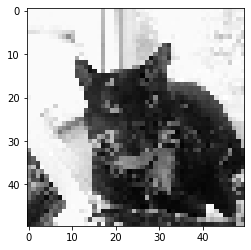

In [6]:
import matplotlib.pyplot as plt
sample_num = 774
plt.imshow(training_data[sample_num][0], cmap = "gray")
plt.show()

# Connect to GPU with CUDA

In [7]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
Tesla K80


In [8]:
#Assign cuda GPU located at location '0' if avaiable
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU, device:", device)
else: 
  device = torch.device("cpu")
  print("Running on the CPU, device:", device)

Running on the GPU, device: cuda:0


# Build the Convnet Model 

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
# Build the convnet class
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)

        # create random data and pass it through the convnet to determin the shape of the flattened output
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        # compute the shape of the flattened output
        if self._to_linear is None:
          self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x
    
    def forward(self, x):
      x = self.convs(x)    # passing through all the conv layers
      x = x.view(-1, self._to_linear)   # flattening 
      # x = torch.flatten(x)
      # self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      # x = F.relu(nn.Linear(self._to_linear, 512))
      x = F.relu(self.fc1(x)) # passing through the first fc layer
      x = self.fc2(x) # bc this is our output layer. No activation here.
  
      return F.softmax(x, dim=1)

# Initial Training and Testing Separately

In [11]:
# Train, test, validation split
X = torch.Tensor([i[0] for i in tqdm(training_data)]).view(-1,50,50)
X = X/255.0         # Scale the image from 0 - 255 to 0 - 1
y = torch.Tensor([i[1] for i in tqdm(training_data)])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

100%|██████████| 24946/24946 [00:00<00:00, 1646955.89it/s]

2494
22452 2494


In [12]:
def train(net):
  # Define Training Parameters
  BATCH_SIZE = 100
  EPOCHS = 5
  LEARNING_RATE = 10**-3
  # Define optimizer and loss_function
  optimizer = optim.Adam(net.parameters(), LEARNING_RATE)
  loss_function = nn.MSELoss()  
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        # Move batches to the GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad() 
        outputs = net(batch_X)     # pass batch_X through the network

        # Calculate in sample accuracy
        matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        in_sample_acc = matches.count(True)/len(matches)

        loss = loss_function(outputs, batch_y)  # compute the loss
        loss.backward()     # apply the loss backwards
        optimizer.step()    # optimize 

    print(f"\nEpoch: {epoch}. Loss: {loss}")
    print("In-sample acc:",round(in_sample_acc, 3))

In [13]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("\nAccuracy: ", round(correct/total, 3))

In [14]:
# Create the network on the gpu
net = Net().to(device)
print(net)
# Train on GPU
train(net)
# Test on GPU
test(net)

  0%|          | 1/225 [00:00<00:32,  6.99it/s]

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


  2%|▏         | 4/225 [00:00<00:06, 35.11it/s]


Epoch: 0. Loss: 0.22595424950122833
In-sample acc: 0.615


  2%|▏         | 4/225 [00:00<00:06, 34.74it/s]


Epoch: 1. Loss: 0.1526680439710617
In-sample acc: 0.808


  2%|▏         | 4/225 [00:00<00:06, 34.67it/s]


Epoch: 2. Loss: 0.14148853719234467
In-sample acc: 0.827


  2%|▏         | 4/225 [00:00<00:06, 35.29it/s]


Epoch: 3. Loss: 0.11567976325750351
In-sample acc: 0.885


  3%|▎         | 85/2494 [00:00<00:02, 842.04it/s]


Epoch: 4. Loss: 0.11241866648197174
In-sample acc: 0.885


100%|██████████| 2494/2494 [00:02<00:00, 876.05it/s]


Accuracy:  0.768


# Improve the Model

In [15]:
def fwd_pass(X, y, train = False):
  if train:
    net.zero_grad()

  outputs = net(X)
  matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()

  return acc, loss


In [16]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device) 
LEARNING_RATE = 10**-3
# Define optimizer and loss_function
optimizer = optim.Adam(net.parameters(), LEARNING_RATE)
loss_function = nn.MSELoss() 

def train(net):
    # Define Training Parameters
    BATCH_SIZE = 100
    EPOCHS = 5
    print(MODEL_NAME)
    
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
                # print(i, i+BATCH_SIZE)
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i:i+BATCH_SIZE]
                
                # Move batches to the GPU
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                
                f.write(f"{MODEL_NAME},{round(time.time(),3)},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
              
            print(f"\nEpoch: {epoch}. Loss: {loss}")
            print("In-sample acc:",round(acc, 3))
train(net)

  1%|▏         | 3/225 [00:00<00:09, 23.67it/s]

model-1610382703


  2%|▏         | 4/225 [00:00<00:07, 31.05it/s]


Epoch: 0. Loss: 0.19343560934066772
In-sample acc: 0.788


  2%|▏         | 4/225 [00:00<00:07, 30.01it/s]


Epoch: 1. Loss: 0.14705045521259308
In-sample acc: 0.769


  2%|▏         | 4/225 [00:00<00:07, 31.47it/s]


Epoch: 2. Loss: 0.11583710461854935
In-sample acc: 0.885


  2%|▏         | 4/225 [00:00<00:07, 30.93it/s]


Epoch: 3. Loss: 0.10959155112504959
In-sample acc: 0.827


100%|██████████| 225/225 [00:07<00:00, 30.63it/s]


Epoch: 4. Loss: 0.10311442613601685
In-sample acc: 0.865


In [17]:
def val_test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

In [ ]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device) 
LEARNING_RATE = 10**-3
# Define optimizer and loss_function
optimizer = optim.Adam(net.parameters(), LEARNING_RATE)
loss_function = nn.MSELoss() 

def train(net):
    # Define Training Parameters
    BATCH_SIZE = 100
    EPOCHS = 8
    print(MODEL_NAME)
    
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
                # print(i, i+BATCH_SIZE)
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i:i+BATCH_SIZE]
                
                # Move batches to the GPU
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                
                # Calculate validation/out-of-sample accuracy at every 10 step
                if i % 10 == 0:
                    val_acc, val_loss = val_test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
                    
            print(f"\nEpoch: {epoch}. Loss: {loss}")
            print("In-sample acc:",round(acc, 3))
            print("Validation acc:",round(val_acc, 3))

train(net)

  1%|          | 2/225 [00:00<00:11, 19.85it/s]

model-1610299522


  1%|▏         | 3/225 [00:00<00:10, 21.06it/s]


Epoch: 0. Loss: 0.17442762851715088
In-sample acc: 0.731
Validation acc: 0.65


  1%|▏         | 3/225 [00:00<00:10, 20.76it/s]


Epoch: 1. Loss: 0.16948887705802917
In-sample acc: 0.75
Validation acc: 0.74


  1%|▏         | 3/225 [00:00<00:10, 20.57it/s]


Epoch: 2. Loss: 0.13467267155647278
In-sample acc: 0.827
Validation acc: 0.8


  1%|▏         | 3/225 [00:00<00:10, 20.67it/s]


Epoch: 3. Loss: 0.12699714303016663
In-sample acc: 0.827
Validation acc: 0.79


  1%|          | 2/225 [00:00<00:12, 18.42it/s]


Epoch: 4. Loss: 0.1028217300772667
In-sample acc: 0.904
Validation acc: 0.78


  1%|▏         | 3/225 [00:00<00:10, 20.84it/s]


Epoch: 5. Loss: 0.09803948551416397
In-sample acc: 0.904
Validation acc: 0.81


  1%|          | 2/225 [00:00<00:11, 19.02it/s]


Epoch: 6. Loss: 0.07524261623620987
In-sample acc: 0.923
Validation acc: 0.78


100%|██████████| 225/225 [00:11<00:00, 20.29it/s]


Epoch: 7. Loss: 0.051328446716070175
In-sample acc: 0.962
Validation acc: 0.79


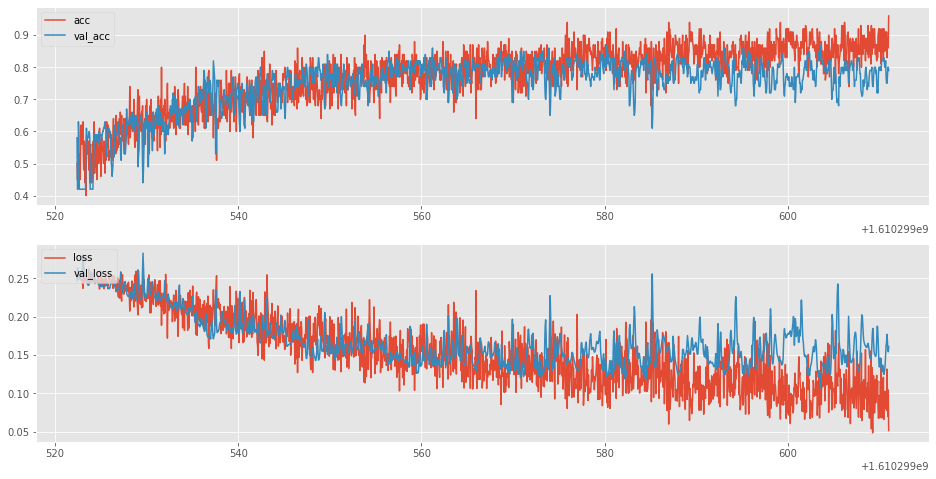

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure(figsize=(16,8))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)


# Final Model

In [24]:
def train(net):
  # Define Training Parameters
  BATCH_SIZE = 100
  EPOCHS = 6
  LEARNING_RATE = 10**-3
  # Define optimizer and loss_function
  optimizer = optim.Adam(net.parameters(), LEARNING_RATE)
  loss_function = nn.MSELoss()  
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        # print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        # Move batches to the GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad() 
        outputs = net(batch_X)     # pass batch_X through the network

        # Calculate in sample accuracy
        matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        in_sample_acc = matches.count(True)/len(matches)

        loss = loss_function(outputs, batch_y)  # compute the loss
        loss.backward()     # apply the loss backwards
        optimizer.step()    # optimize 

    print(f"\nEpoch: {epoch}. Loss: {loss}")
    print("In-sample acc:",round(in_sample_acc, 3))

In [25]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("\nAccuracy: ", round(correct/total, 3))

In [26]:
# Create the network on the gpu
net = Net().to(device)
print(net)
# Train on GPU
train(net)
# Test on GPU
test(net)

  1%|▏         | 3/225 [00:00<00:08, 26.44it/s]

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


  2%|▏         | 4/225 [00:00<00:06, 34.46it/s]


Epoch: 0. Loss: 0.23214243352413177
In-sample acc: 0.558


  2%|▏         | 4/225 [00:00<00:06, 33.13it/s]


Epoch: 1. Loss: 0.16624367237091064
In-sample acc: 0.808


  2%|▏         | 4/225 [00:00<00:06, 34.42it/s]


Epoch: 2. Loss: 0.1277293711900711
In-sample acc: 0.885


  2%|▏         | 4/225 [00:00<00:06, 32.97it/s]


Epoch: 3. Loss: 0.10004506260156631
In-sample acc: 0.846


  2%|▏         | 4/225 [00:00<00:06, 34.52it/s]


Epoch: 4. Loss: 0.09270794689655304
In-sample acc: 0.865


  4%|▎         | 91/2494 [00:00<00:02, 901.74it/s]


Epoch: 5. Loss: 0.08228973299264908
In-sample acc: 0.846


100%|██████████| 2494/2494 [00:02<00:00, 878.11it/s]


Accuracy:  0.79


# Prediction

In [27]:
def make_predict_data(path, img_size):
  # in case it is not an image 
  try:
    # read image in GRAYSCALE
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # set the size to be 50 * 50 pix
    img = cv2.resize(img, (img_size, img_size))
  
  except Exception as e:
    print(str(e))
    pass
    
  return np.array(img)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [239 239 239 ... 239 239 239]
 ...
 [239 239 239 ... 235 239 239]
 [239 239 239 ... 237 239 239]
 [255 255 255 ... 255 255 255]]


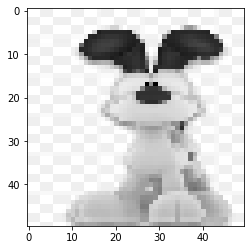

tensor([0., 1.], device='cuda:0', grad_fn=<SelectBackward>)
This is a dog


In [30]:
# copy the image path
PredictDir = "/content/drive/MyDrive/ColabNotebooks/CatsVSDogsPredict/174.png"
IMG_SIZE = 50

# Get predict_data
predict_data = make_predict_data(PredictDir, IMG_SIZE)
print(predict_data)

plt.imshow(predict_data, cmap = "gray")
plt.show()

# Predict 
x = torch.Tensor(predict_data).view(-1,50,50)
prediction = net(x.view(-1, 1, 50, 50).to(device))[0]
predicted_class = torch.argmax(prediction)
print(prediction)
if predicted_class == 0:
  print("This is a cat")
if predicted_class == 1:
  print("This is a dog")